# Example: Generate 2D input data for PyRayHF

This example shows how to generate 2D density and magnetic field data using PyIRI that can be used for 2D PyRayHF ray tracing.

The 2D domain is always vertical (z axis in altitude, x axis in horizontal distance) and is defined as follows:
- The ray transmitter location defines the origin of the 2D plane (x=0, z=0) 
- The orientation of the x axis is defined by an azimuth measured clockwise from geographic North
- The extent of the x and z axes are defined by a user-provided great-circle-distance and maximum altitude, respectively.

PyIRI is used to generate IRI electron density and IGRF magnetic field for each point within the 2D domain.

1. Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PyIRI
import PyIRI.main_library as pyiri
import PyRayHF
import PyRayHF.library as ml
import cartopy.feature as cfeature
import cartopy.crs as ccrs

2. PyIRI Input and Plane Definition

In [2]:
# Time and solar conditions for PyIRI
year  = 2025
month = 9
day   = 1
UT    = 0   # UT Time in Hours
F107  = 204 # F10.7 in SFU

# Transmitter location
tlat = 0      # Latitude in degrees
tlon = -150   # Longitude in degrees

# Length and orientation of 2D plane
azimuth      = 0     # Azimuth in degrees 
gcd          = 1000  # Great circle distance in km

# Horizontal Grid Resolution
dx = 1 # Horizontal grid resolution in km

# Vertical Grid Definition
min_alt = 60
max_alt = 700
n_z = 500
aalt = np.linspace(min_alt, max_alt, n_z)
aalt = np.insert(aalt, 0, 0) # Include 0 km

3. Generate Density and Magnetic Field Data

In [3]:
# Location to save output 
save_path = './Example_input_2D.p' # Must include '.p'

# Generate 2D Data
domain_data = ml.generate_input_2D(year, month, day, UT, tlat, tlon, dx, aalt, gcd, azimuth, F107, save_path=save_path)

`generate_input_2D()` returns a dictionary in the following format:

out_data : dict

- 'xgrid' : x coordinate array of horizontal grid in km
- 'zgrid' : z coordinate array of vertical grid in km
- 'xlat' : Latitude in degrees of each point in xgrid
- 'xlon' : Longitude in degrees of each point in xgrid
- 'den' : 2D array of electron density in m^-3
- 'bmag' : 2D array of magnetic field strenth in T
- 'bpsi' : 2D array of magnetic field angle to vertical in degrees
- 'F2' : PyIRI output dictionary for F2 region at all (xlon, xlat)
- 'F1' : PyIRI output dictionary for F1 region at all (xlon, xlat)
- 'E' : PyIRI output dictionary for E region at all (xlon, xlat)
- 'Es' : PyIRI output dictionary for Es region at all (xlon, xlat)
- 'year' : Year used to run PyIRI for this data 
- 'month' : Month used to run PyIRI for this data 
- 'day' : Day of month used to run PyIRI for this data 
- 'UT' : Unniversal time used to run PyIRI for this data 
- 'F107' : F10.7 in SFU used to run PyIRI for this data
- 'tlat' : Latitude in degrees of transmitter
- 'tlon' : Longitude in degrees of transmitter
- 'az' : Azimuth from transmitter in degrees (measured clockwise from geographic north) that defines the orientation of the output domain

4. Plot the 2D Domain Density and Magnetic Field Data

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/var/folders/hx/vfmrc7fn3cb_5y7fpsjwylcw0000gq/T/ipykernel_33947/2571095818.py:15: SyntaxWarning: invalid escape sequence '\m'
  fig.colorbar(pcm1, ax=ax[1], label='$|\mathbf{B}|$ ($\mu$T)')


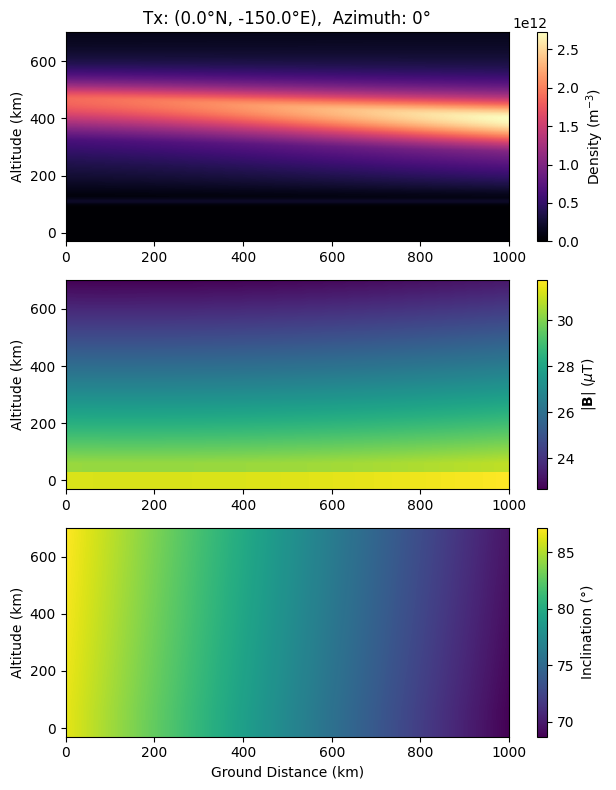

In [4]:
# Initialize Figure
fig, ax = plt.subplots(3, 1, figsize=(6.4,8))

# Grid for Plotting
X, Z = np.meshgrid(domain_data["xgrid"], domain_data["zgrid"])

# Plot Density
pcm0 = ax[0].pcolormesh(X, Z, domain_data["den"], cmap='magma', shading='auto')
fig.colorbar(pcm0, ax=ax[0], label='Density (m$^{-3}$)')
ax[0].set_title(f"Tx: ({tlat:.1f}°N, {tlon:.1f}°E),  Azimuth: {azimuth}°", fontsize=12)
ax[0].set_ylabel("Altitude (km)")

# Magnetic Field Magnitude
pcm1 = ax[1].pcolormesh(X, Z, domain_data["bmag"] * 1e6, cmap='viridis', shading='auto')
fig.colorbar(pcm1, ax=ax[1], label='$|\mathbf{B}|$ ($\mu$T)')
ax[1].set_ylabel("Altitude (km)")

# Inclination
pcm2 = ax[2].pcolormesh(X, Z, domain_data["bpsi"], cmap='viridis', shading='auto')
fig.colorbar(pcm2, ax=ax[2], label='Inclination (°)')
ax[2].set_xlabel("Ground Distance (km)")
ax[2].set_ylabel("Altitude (km)")

plt.tight_layout()

# Save to file
plt.savefig('../figures/Input_Data_2D.png') 

5. Generate Background PyIRI Data for Plotting

In [5]:
# PyIRI Grid Defintion
# Horizontal Grid
dlon = 1 # lat/lon grid resolution in degrees
dlat = 1 
lat_span = 25 # lat/lon grid span in degrees
lon_span = 25
alon_2d, alat_2d = np.meshgrid(np.linspace(tlon-lon_span/2,tlon+lon_span/2,int(lon_span/dlon)),
                               np.linspace(tlat-lat_span/2,tlat+lat_span/2,int(lat_span/dlat)))

alon = np.reshape(alon_2d, alon_2d.size)
alat = np.reshape(alat_2d, alat_2d.size)

# Altitude Grid
alt_res = 2
alt_min = 90
alt_max = 700
aalt = np.arange(alt_min, alt_max, alt_res)

# Run PyIRI to get Background
(F2, F1, E, 
        Es, _, _, den) = pyiri.IRI_density_1day(year, month, day, np.array([UT]), alon, 
                                             alat, aalt, F107, PyIRI.coeff_dir, 0)

nmf2 = np.reshape(F2["Nm"], alon_2d.shape)

6. Plot the orientation of the 2D domain on a lat/lon map

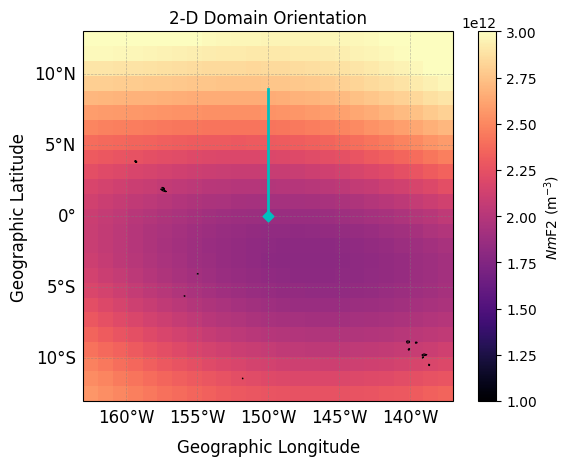

In [9]:
# Initialize Figure
fig2, ax2 = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the background data
p = ax2.pcolormesh(alon_2d,alat_2d,nmf2,cmap='magma', vmin=1e12, vmax=3e12)
plt.colorbar(p, ax=ax2, label='$Nm$F2 (m$^{-3}$)')

# Plot a map overlay
ax2.coastlines(color='black', linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='none', edgecolor='black')

# Show Lat and Lon tick marks
gl = ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Axis Labels
ax2.text(0.5, -0.1, 'Geographic Longitude', transform=ax2.transAxes,
        ha='center', va='top', fontsize=12)
ax2.text(-0.15, 0.5, 'Geographic Latitude', transform=ax2.transAxes,
        ha='right', va='center', rotation='vertical',
        fontsize=12)

# Plot the 2D domain 
ax2.plot(domain_data['xlon'][:],domain_data['xlat'][:],'c',linewidth=2, zorder=100)

# Plot Transmitter Location
ax2.scatter(domain_data['tlon'],domain_data['tlat'],marker='D',c='c',s=30, zorder=200)

# Optional plot title
plt.title('2-D Domain Orientation')

# Save to file
plt.savefig('../figures/2D_Domain_Orientation.png')
    